In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from queue import PriorityQueue

Firstly lets create an instance generator, so we can test our algorithm once implemented, as well as some auxiliar functions that are needed for the implementation of multiple algorithms.

In [ ]:
# Generate random instance of size 2^i
# where every point belongs to a grid of
# edge 2^i.

def generate_instance(i=4, maxsize=1024):
  V = np.random.randint(0, maxsize, (2**i, 2))
  return V

In [ ]:
# Calculate distance between two points
# using either euclidian or manhattan

def euclidian(p1, p2):
  return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def manhattan(p1, p2):
  return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

In [ ]:
# Calculate an adjacency matrix to avoid
# recalculation the distance between points

def adj(V, cost=euclidian, timing=False):
  
  if timing:
    start = tm.time()
  
  A = np.zeros((len(V),len(V)))
  for i in range(len(V)):
    for j in range(len(V)):
      A[i][j] = cost(V[i], V[j])

  if timing:
    end = tm.time()
    return A, end - start
  
  return A

In [ ]:
# Prim's Minimum Spanning Tree Algorithm
# as it is required step for solving both
# Twice-Around-the-Tree and Christofides

# The tree itself is represented as list of
# lists, each list representing the vertices
# that branches from the index


def Prims_MST(V, A=None, cost=euclidian, timing=False):

  if timing:
    start = tm.time()

  if A is None:
    A = adj(V, cost)

  offTree = set(range(1,len(V)))
  onTree = {0}
  Tree = [[] for _ in range(len(V))]

  while offTree:
    p1, p2 = [0,0], [0,0]
    minimum = np.inf

    for i in onTree:
      for j in offTree:
        c = A[i,j]
        if c < minimum:
          p1 = i
          p2 = j
          minimum = c

    Tree[p1].append(p2)
    offTree.remove(p2)
    onTree.add(p2)

  if timing:
    end = tm.time()
    return Tree, end - start

  return Tree

In [ ]:
# Walk the path to calculate its cost

def path_cost(A, path):
  cost = 0
  for i in range(len(path)-1):
    cost += A[path[i], path[i+1]]

  return cost

Implementing TSP using a Branch-and-Bound

In [ ]:
# As we want a way to guess how good is
# the path so far without expending much
# resources, we will create a matrix
#     min_adj[V] = [lowest, second lowest]

# and when adding the edge i->j to path
# we assume the new minimum bound is
#     guessBound -= (min_adj[i,0] + min_adj[j,1])/2 
#     pathCost += A[i,j]
# and the weight of a partial solution
# is guessBound + pathCost

def initial_guess(A):
  
  guess = np.zeros((len(A), 2))
  cost = 0.

  for i in range(len(A)):
    first = np.inf
    for j in range(len(A)):
      if i == j:
        continue
      elif A[i,j] <= first and i != j:
        second = first
        first = A[i,j]
      elif A[i,j] < second:
        second = A[i,j]

    guess[i,:] = [first, second]
    cost += first + second
  
  return guess, cost/2

def adjust_bound(A, min_adj, i, j):
  return (min_adj[i,0] + min_adj[j,1])/2

In [ ]:
def TSP_BranchAndBound(V, A=None, cost=euclidian, timing=False, op='rec'):
  
  if timing:
    start = tm.time()

  if A is None:
    A = adj(V, cost)
  
  best = np.inf
  best_path = []

  q = PriorityQueue()
  # element = (weight, cost, bound, path, offPath)

  offPath = set(range(1,len(A)))
  path = [0]
  cost = 0
  min_adj, bound = initial_guess(A)

  root = (cost + bound, cost, bound, path, offPath)
  q.put(root)

  while not q.empty():
    weight, cost, bound, path, offPath = q.get()
    
    # if solution can't be better than best
    if weight >= best:
      continue

    # if path completed, evalue solution
    elif len(offPath) == 0:
      cost += A[path[-1], 0]
      path.append(0)
      if cost < best:
        
        best = cost
        
        best_path = path
    
    # branching
    else:
      for k in offPath:
        k_cost = cost + A[path[-1], k]
        k_bound = bound - adjust_bound(A, min_adj, path[-1], k)
        k_path = path.copy()
        k_path.append(k)
        k_off = offPath.copy()
        k_off.remove(k)

        # only store promissing branches
        if k_cost + k_bound < best:
          q.put((k_cost + k_bound, k_cost, k_bound, k_path, k_off))

  if timing:
    end = tm.time()
    return [best, end - start, best_path]
  
  return [best, best_path]

Implementing TSP using Twice-Around-the-Tree

In [ ]:
# Walk around tree, taking shortcuts
# at the end of a branch

def tree_walk(T, n):
  
  path = [n]
  for i in T[n]:
    path += tree_walk(T, i)

  return path

In [ ]:
def TSP_TwiceAroundTree(V, A=None, T=None, cost=euclidian, timing=False):
  
  if timing:
    start = tm.time()

  if A is None:
    A = adj(V, cost)
  
  if T is None:
    T = Prims_MST(V, A, cost)
  
  path = tree_walk(T, 0)
  path.append(0)

  total = path_cost(A, path)

  if timing:
    end = tm.time()
    return [total, end - start, path]
    
  return [total, path]

Implementing TSP using Christofides


In [ ]:
# Find the nodes of odd degree on the tree.
# The root is odd if they have a odd number
# of branches, while branches are of if they
# have a even number of sub-branches

def find_odd(T):

  odd = []

  if len(T[0]) % 2 == 1:
    odd.append(0)

  for i in range(1, len(T)):
    if len(T[i]) % 2 == 0:
      odd.append(i)

  return odd

In [ ]:
# Turn edge sequence into path

def seq_to_path(s):

  path = []
  for i in s:
    path.append(i[0])
  path.append(0)

  return path

# Remove repeated vertices from path
# Path contains numbers from 0 to n-1

def reduce_path(path, n):
  p = []
  visited = [False]*n

  for i in path:
    if not visited[i]:
      visited[i] = True
      p.append(i)
  p.append(0)

  return p

In [ ]:
# since the project specifications allows
# the use of networkx and I can't think of
# an efficient way of implementing it,
# let's use that like cowards.

import networkx as nx
# vergonha, desgraça
# humilhação para toda uma raça

def min_matching(A, odd):

  G = nx.Graph()
  G.add_nodes_from(odd)

  edges = []
  for i in range(len(odd)):
    for j in range(i+1,len(odd)):
      edges.append((odd[i], odd[j], A[odd[i], odd[j]]))
  
  G.add_weighted_edges_from(edges)

  return nx.min_weight_matching(G)

In [ ]:
def TSP_Christofides(V, A=None, T=None, cost=euclidian, timing=False):
  
  if timing:
    start = tm.time()

  if A is None:
    A = adj(V, cost)
  
  if T is None:
    T = Prims_MST(V, A, cost)
  
  odd = find_odd(T)
  M = min_matching(A, odd)
  
  # now we create a new graph to run the 
  # eulerian circuity
  G = nx.MultiGraph()
  G.add_nodes_from(range(len(V)))

  edges = list(M)
  for i in range(len(T)):
    for j in T[i]:
      edges.append((i,j))
  
  G.add_edges_from(edges)
  seq = nx.eulerian_circuit(G)
  
  # now we turn the edge sequence into
  # a path like the other and calculate
  # the cost
  
  path = seq_to_path(seq)
  path = reduce_path(path, len(V))
  total = path_cost(A, path)

  if timing:
    end = tm.time()
    return [total, end - start, path]
    
  return [total, path]

Now that everything supposedly works, let's test it.

In [ ]:
np.random.seed(27)

In [ ]:
# Plot a single solution

def plot_sol(V, sol, name=''):

  if len(sol) == 3:
    plt.title(
                  "cost = " + 
                  str(np.round(sol[0], decimals=3)) +
                  ", time = " +
                  str(np.round(sol[1], decimals=3))
                 )
    plt.scatter(V[:,0],V[:,1], s=100, color='black')
    for i in range(len(sol[2])):
      plt.plot([V[sol[2][i-1],0],V[sol[2][i],0]], [V[sol[2][i-1],1],V[sol[2][i],1]], 'r-.', lw=3)
  else:
    plt.title(
                  "cost = " + 
                  str(np.round(sol[0], decimals=3))
                 )
    plt.scatter(V[:,0],V[:,1], s=100, color='black')
    for i in range(len(sol[1])):
      plt.plot([V[sol[1][i-1],0],V[sol[1][i],0]], [V[sol[1][i-1],1],V[sol[1][i],1]], 'r-.', lw=3)
  plt.title(name)
  plt.show()

In [ ]:
# Plot in a graph the vertices and the
# paths taken by each algorithm, as well
# as the total cost and time of each

### all three

def compare_3(V, BnB, TAT, Chris, cost="Euclidian"):
  fig, axs = plt.subplots(1,3, figsize=(24,8))
  
  name = ['Branch and Bound', 'Twice Around Tree', 'Christofides']
  solution = [BnB, TAT, Chris]
  style = ['r-.', 'g-.', 'b-.']
  for i in range(3):
    axs[i].set_title(
                     name[i] +
                     ", cost = " + 
                     str(np.round(solution[i][0], decimals=3)) +
                     ", time = " +
                     str(np.round(solution[i][1], decimals=3)) +
                     's'
                    )
    axs[i].scatter(V[:,0],V[:,1], s=100, color='black')
    for j in range(len(solution[i][2])):
      axs[i].plot([V[solution[i][2][j-1],0],V[solution[i][2][j],0]], [V[solution[i][2][j-1],1],V[solution[i][2][j],1]], style[i], lw=3)

  fig.suptitle(str(len(V)) + " vertices, " + cost, fontsize=15)
  plt.show()

### Chris and TAT

def compare_2(V, TAT, Chris, cost="Euclidian"):
  fig, axs = plt.subplots(1,2, figsize=(16,8))
  
  name = ['Twice Around Tree', 'Christofides']
  solution = [TAT, Chris]
  style = ['g-.', 'b-.']
  for i in range(2):
    axs[i].set_title(
                     name[i] +
                     ", cost = " + 
                     str(np.round(solution[i][0], decimals=3)) +
                     ", time = " +
                     str(np.round(solution[i][1], decimals=3)) +
                     's'
                    )
    axs[i].scatter(V[:,0],V[:,1], s=100, color='black')
    for j in range(len(solution[i][2])):
      axs[i].plot([V[solution[i][2][j-1],0],V[solution[i][2][j],0]], [V[solution[i][2][j-1],1],V[solution[i][2][j],1]], style[i], lw=3)

  fig.suptitle(str(len(V)) + " vertices, " + cost, fontsize=15)
  plt.show()

Firstly, let's compare small sizes of the problem using both euclidian and manhattan distance.

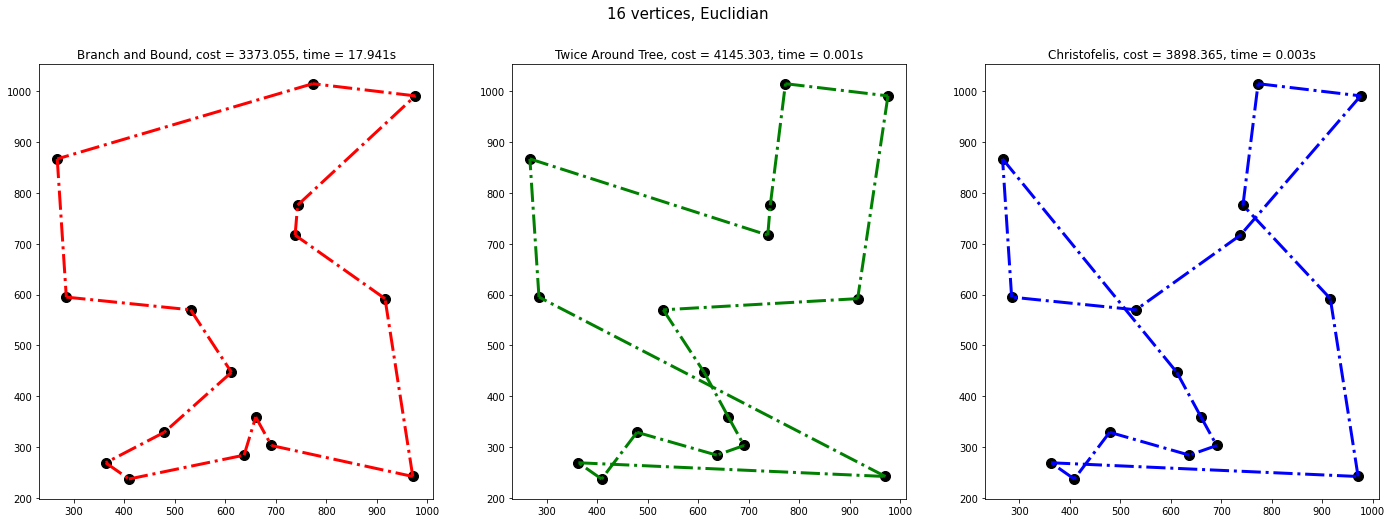

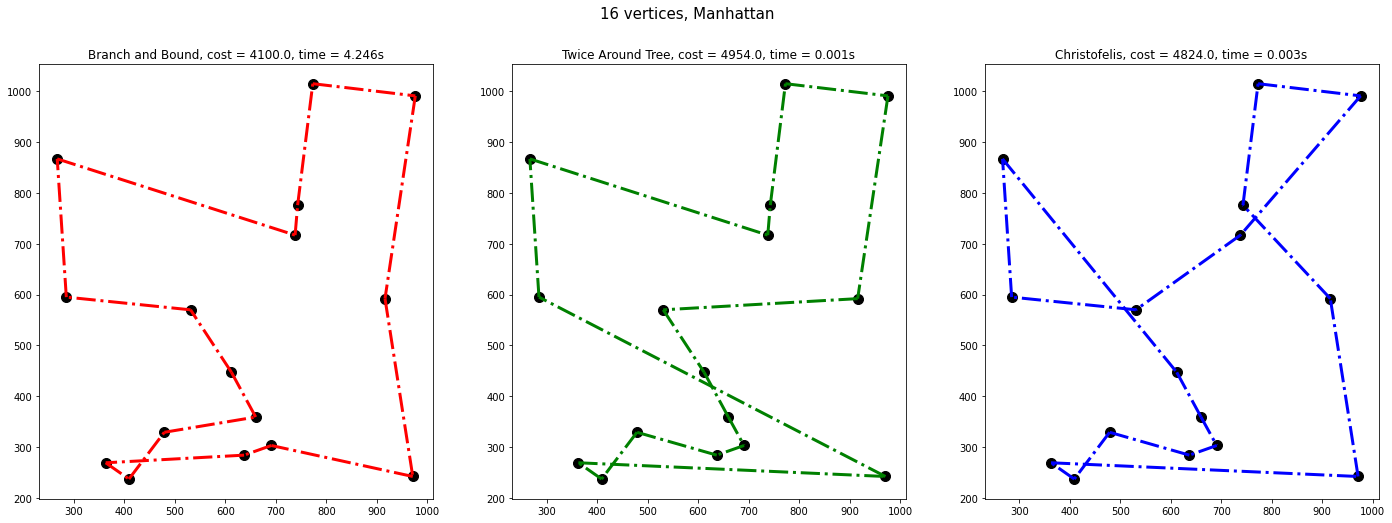

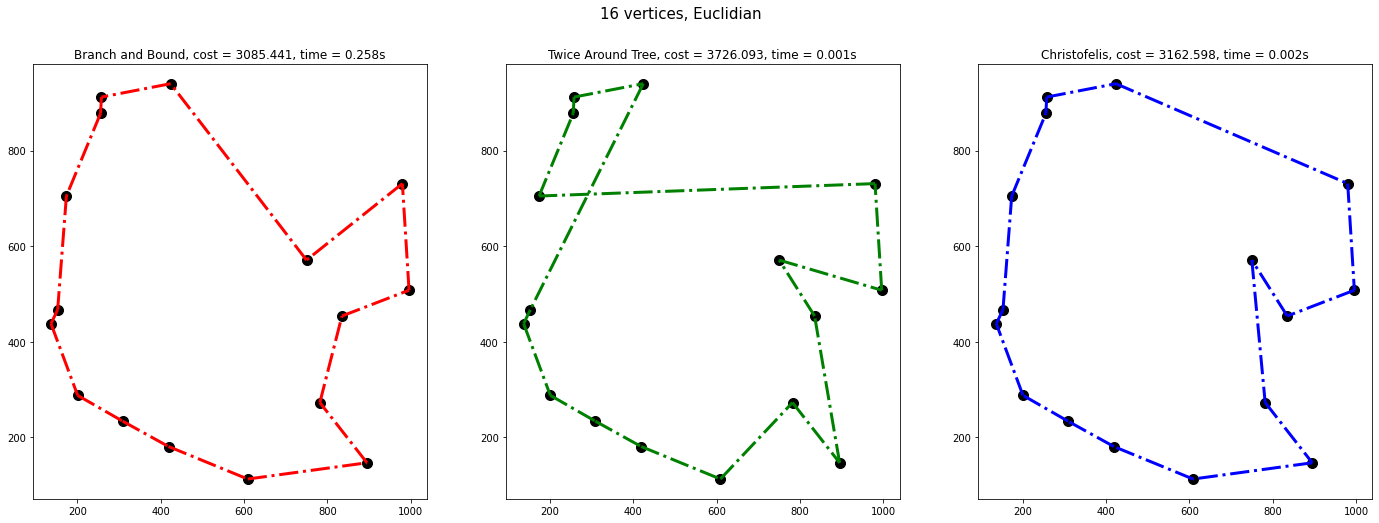

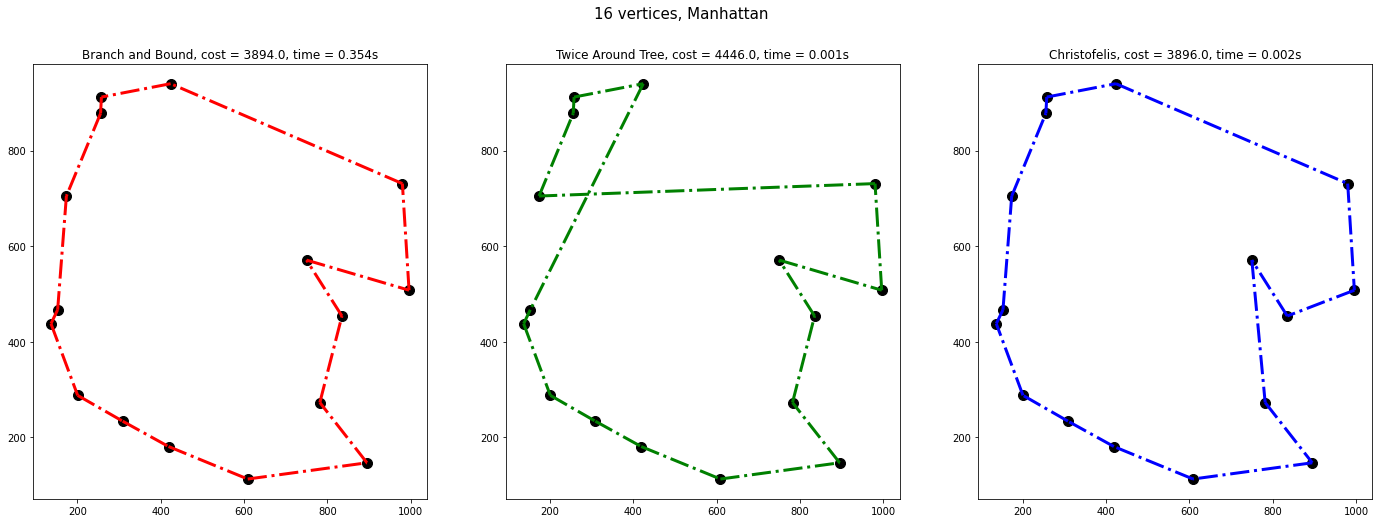

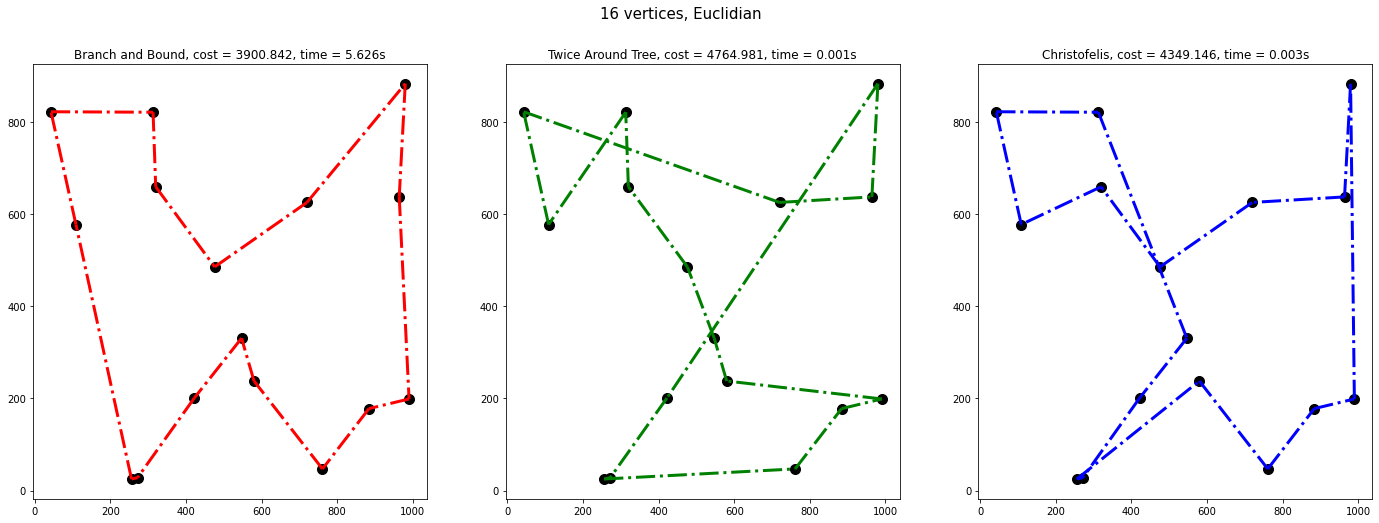

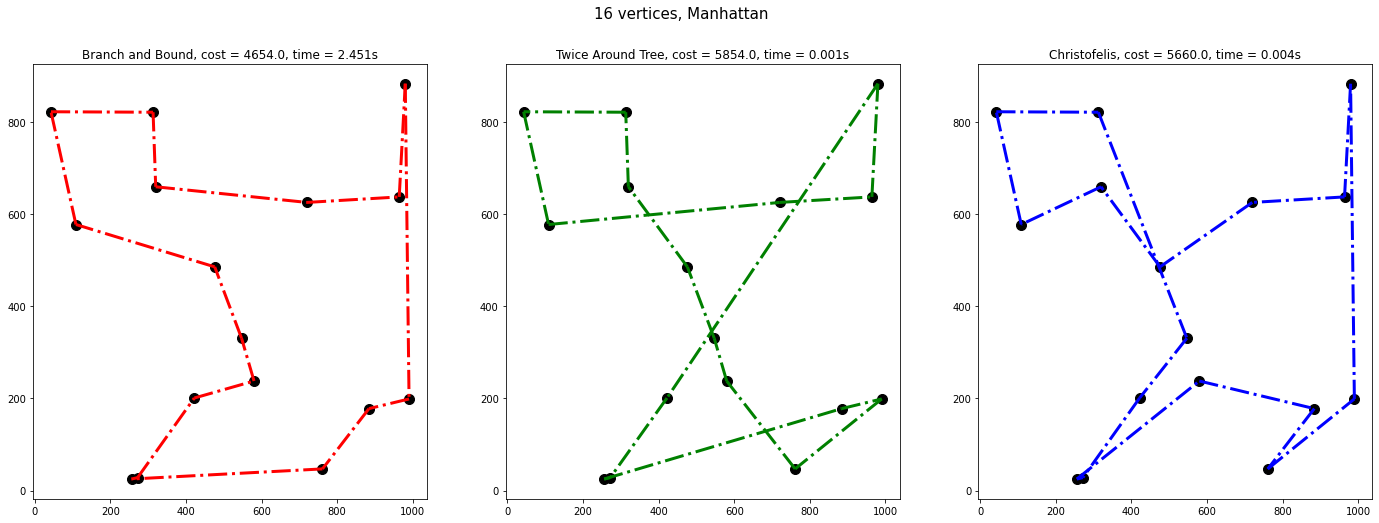

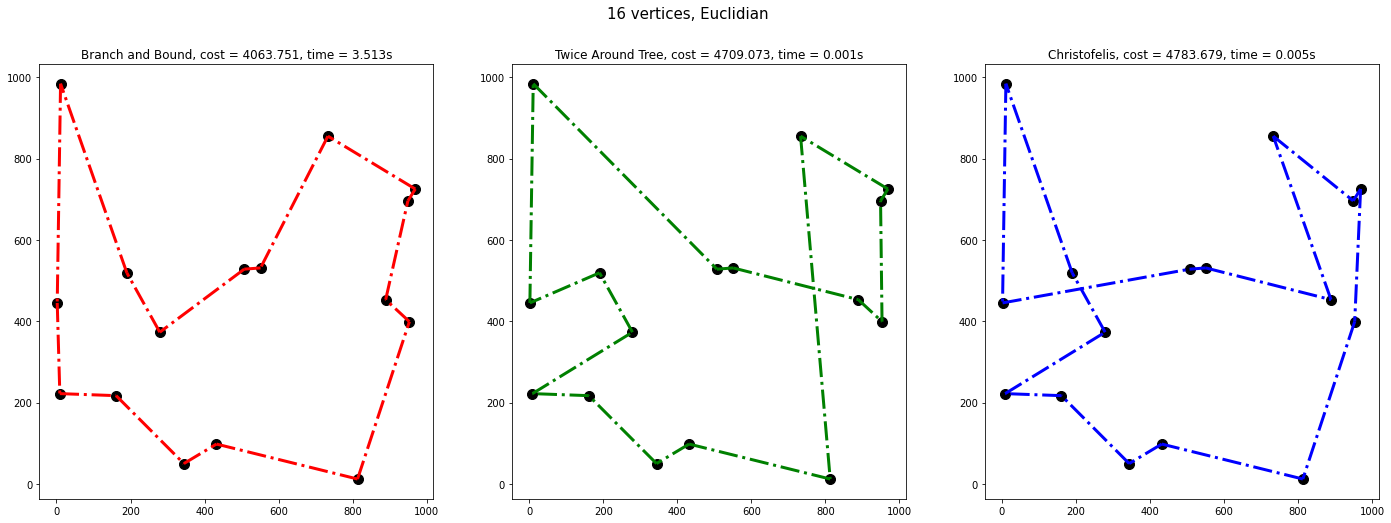

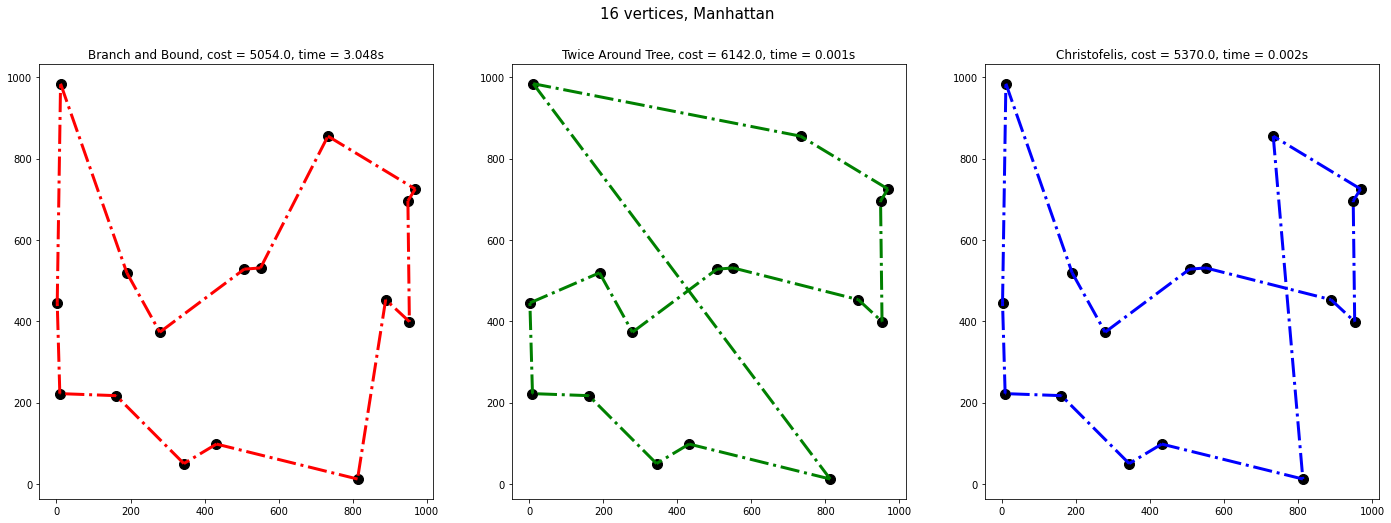

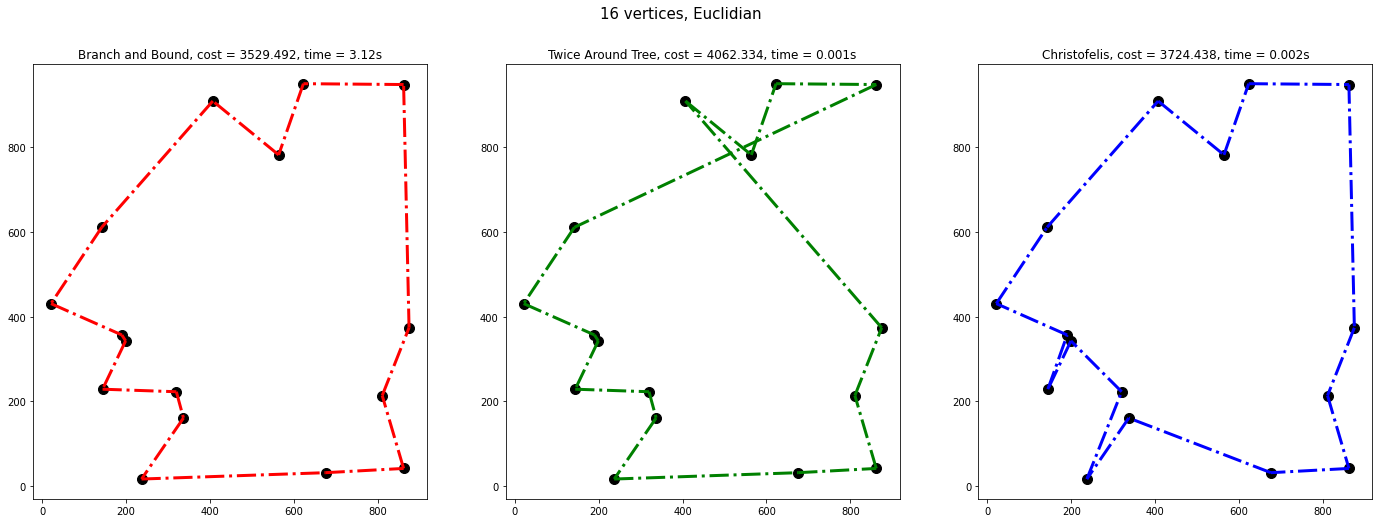

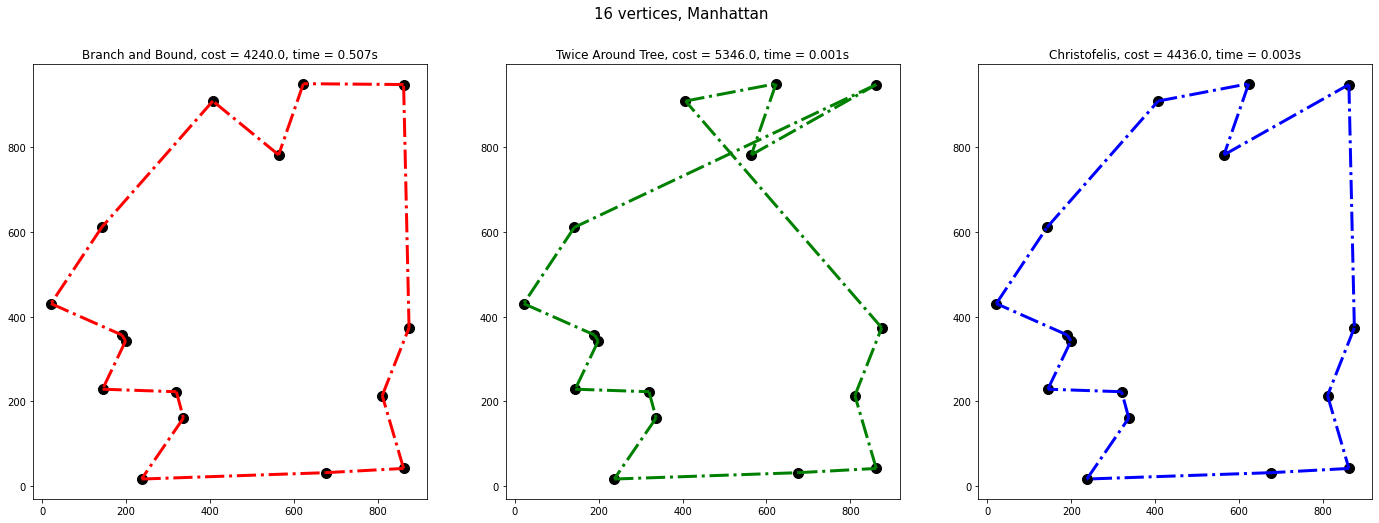

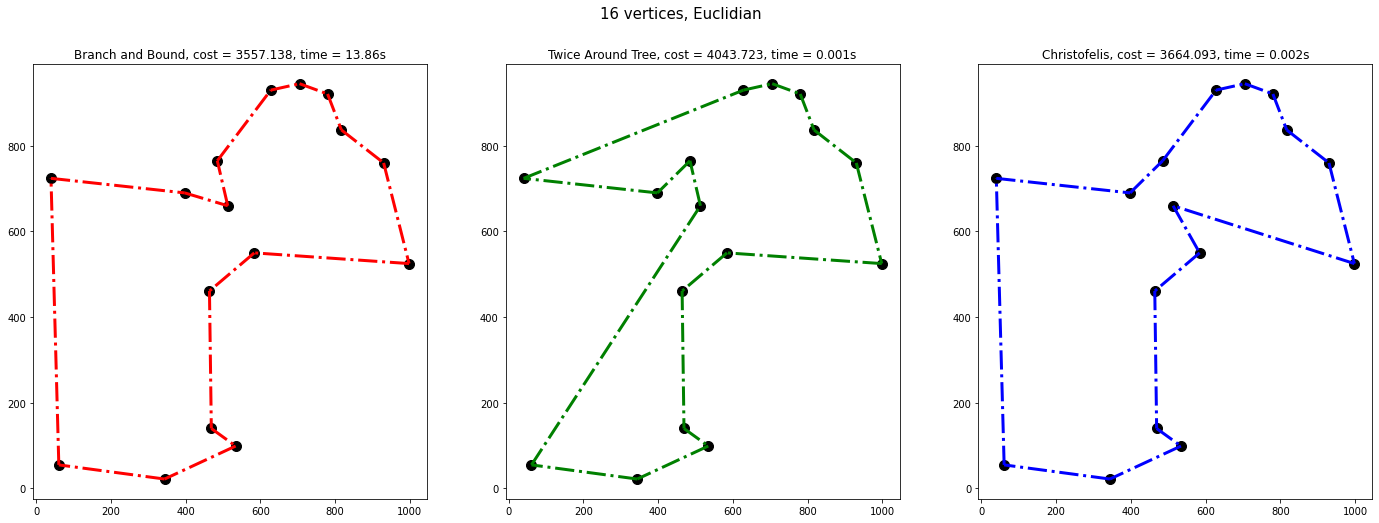

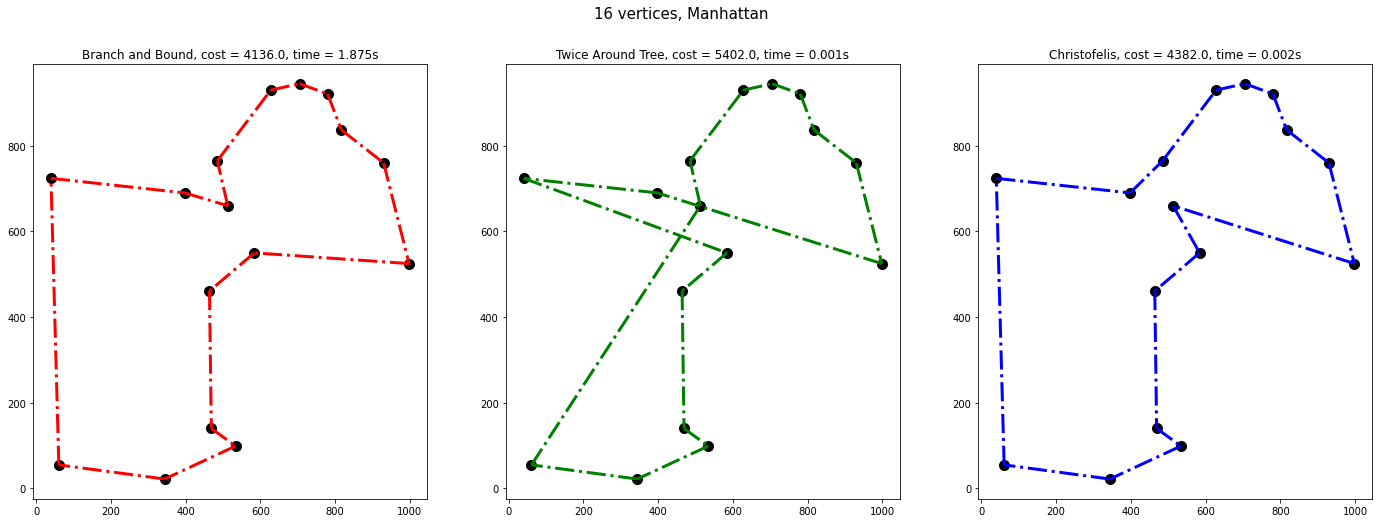

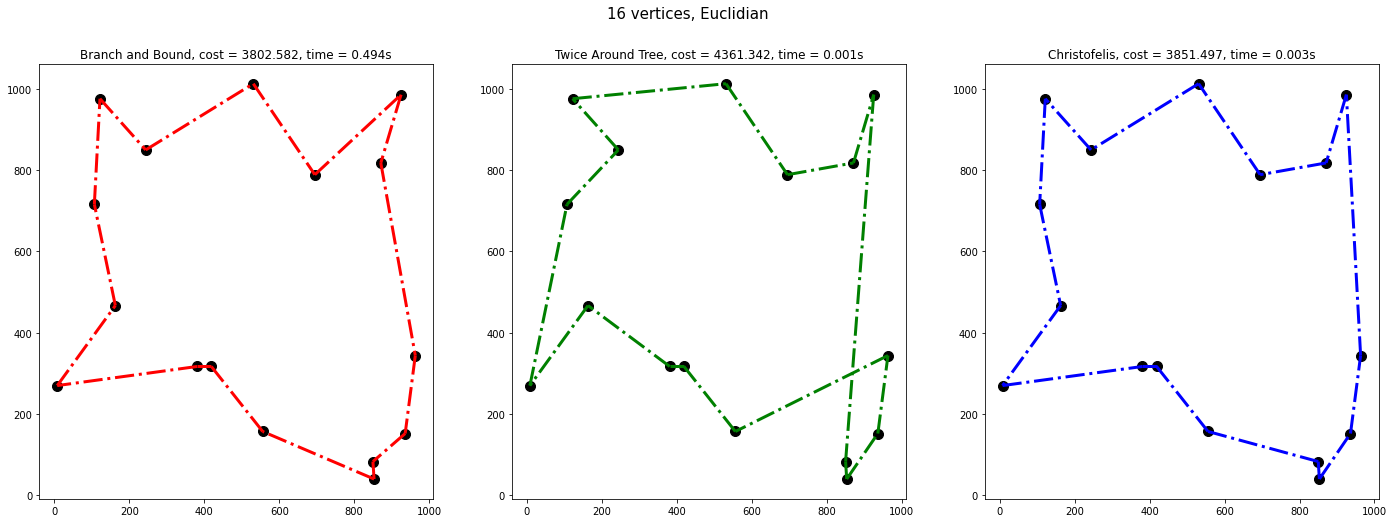

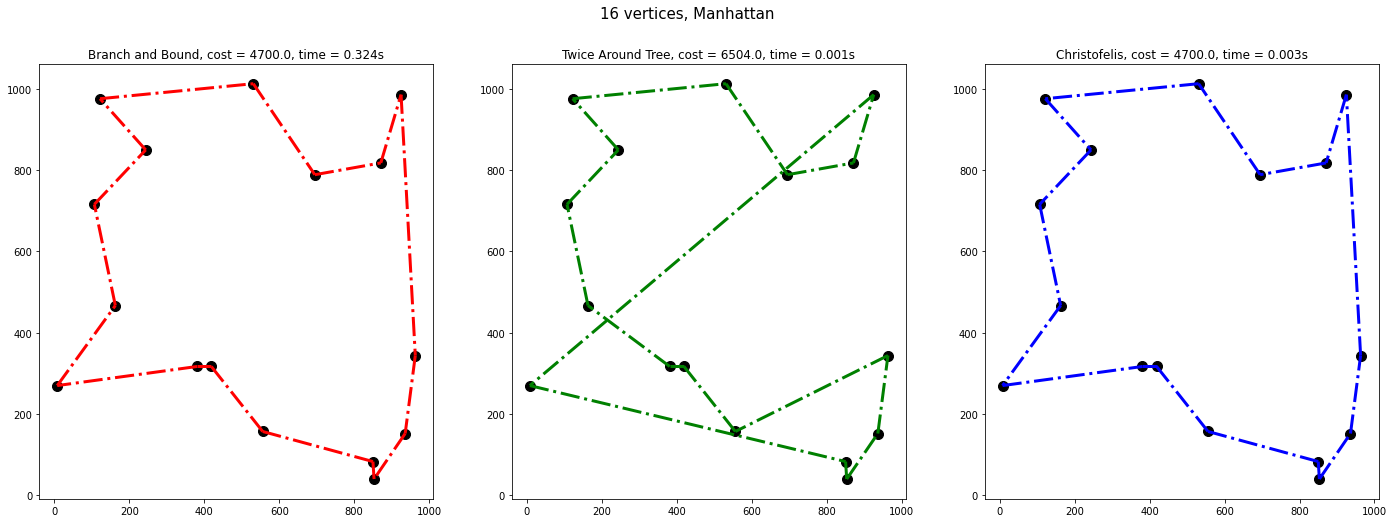

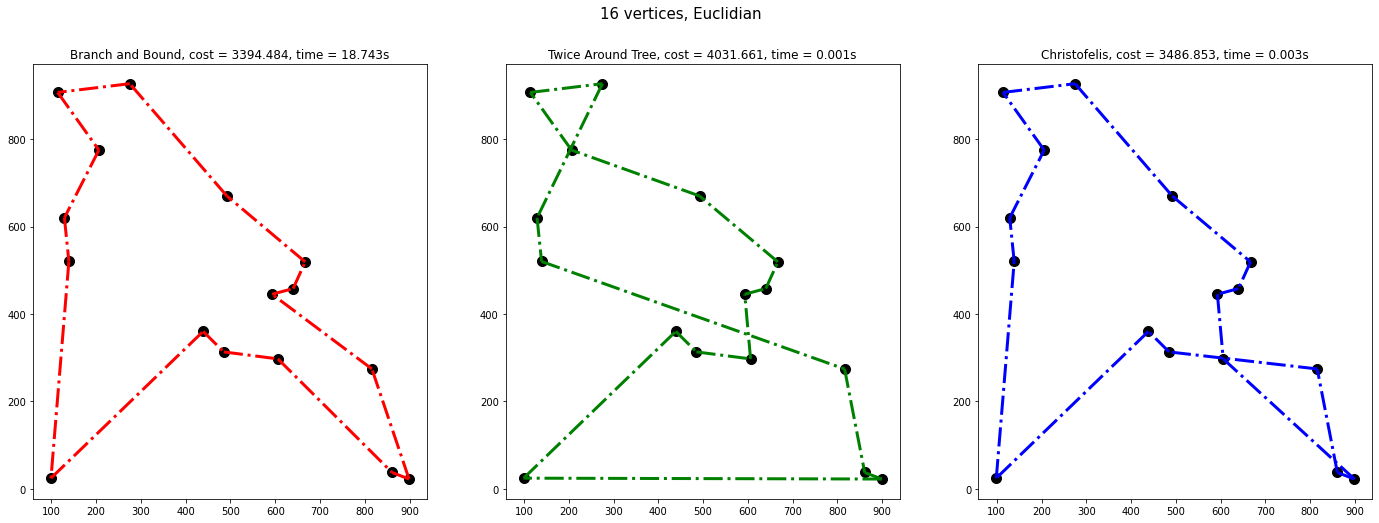

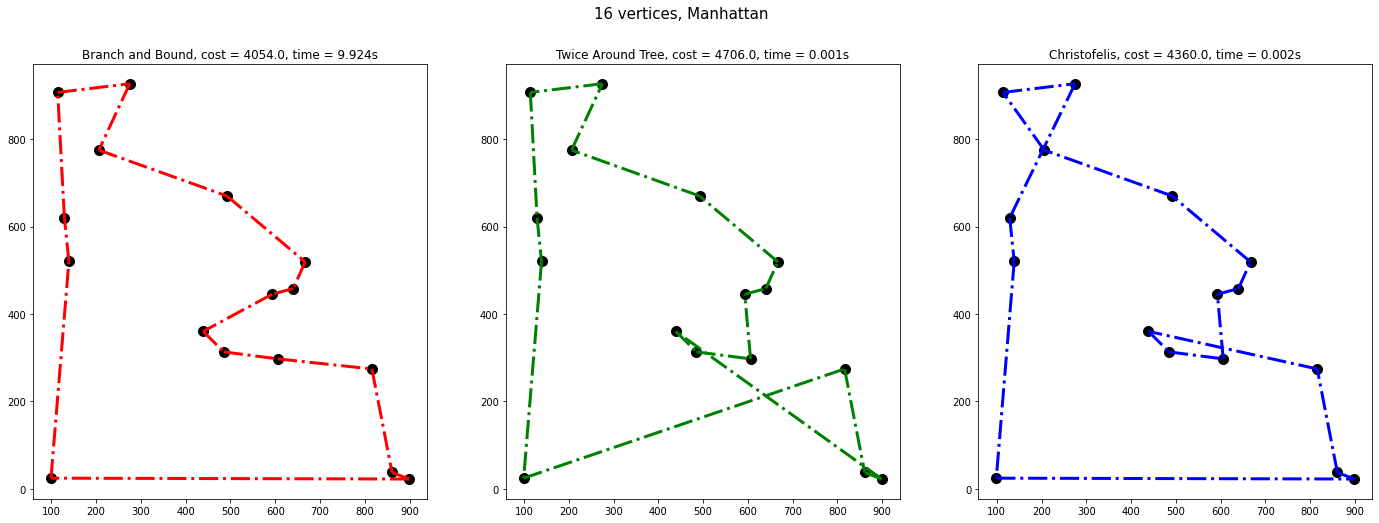

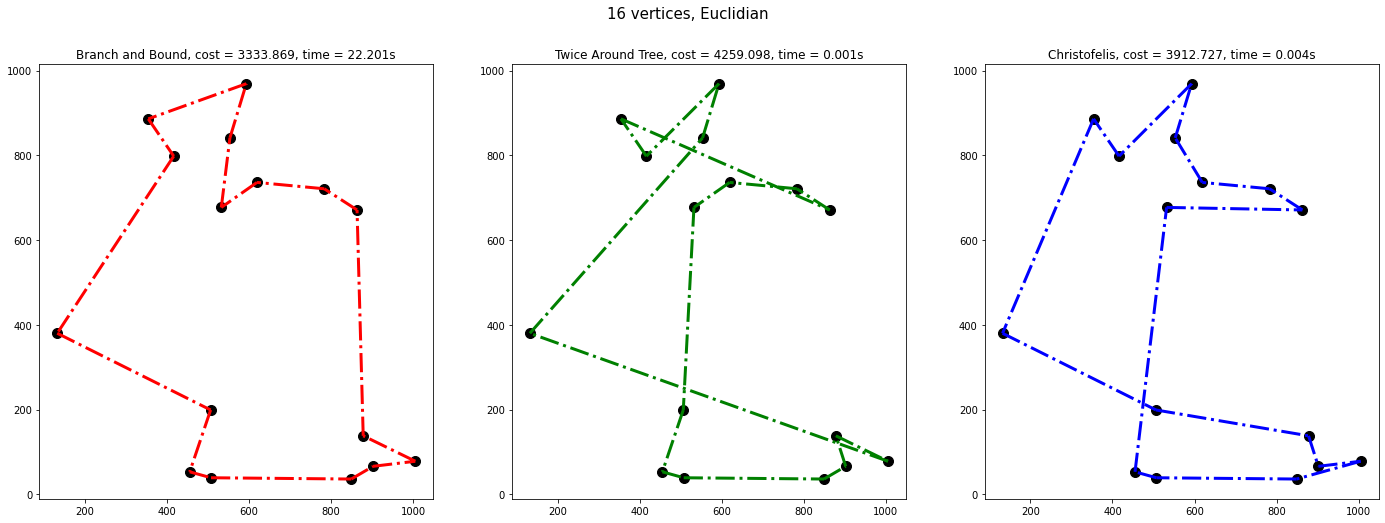

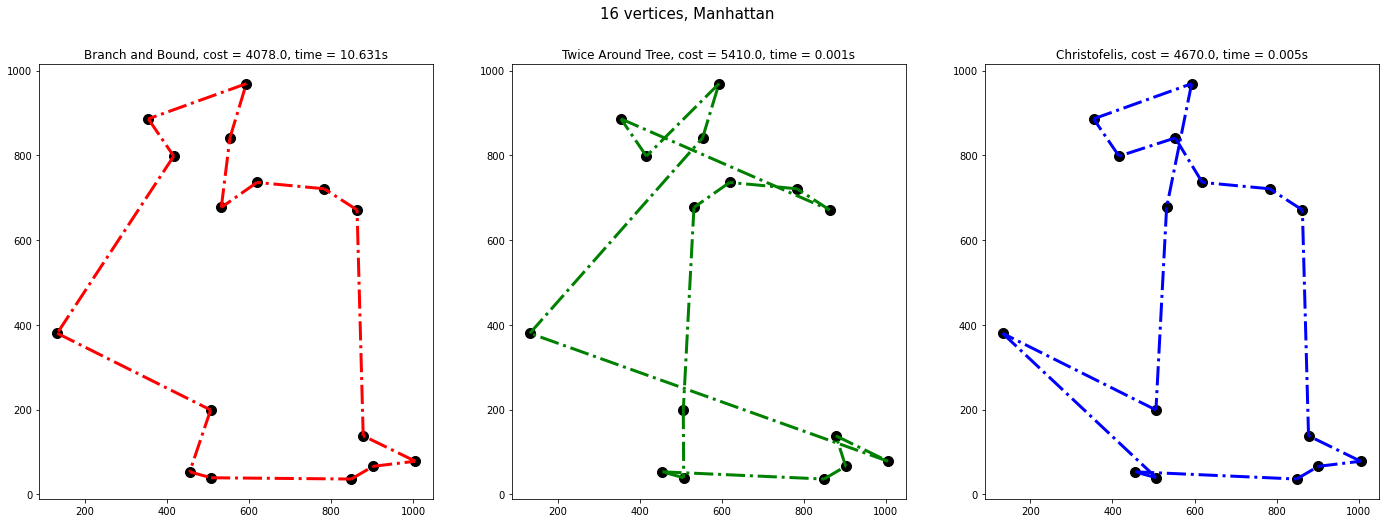

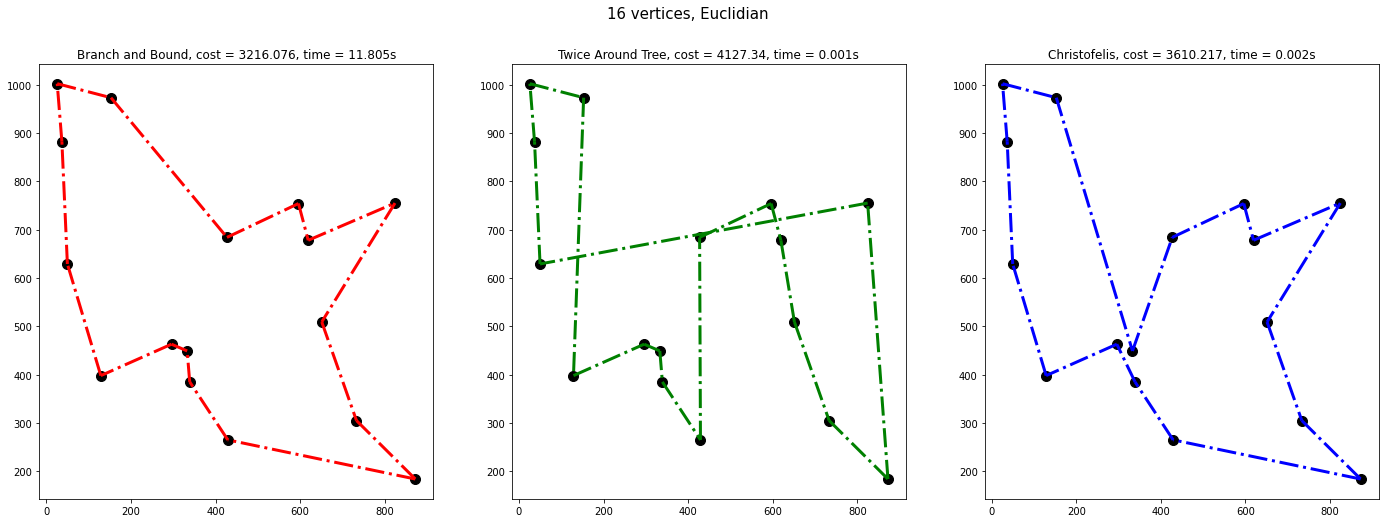

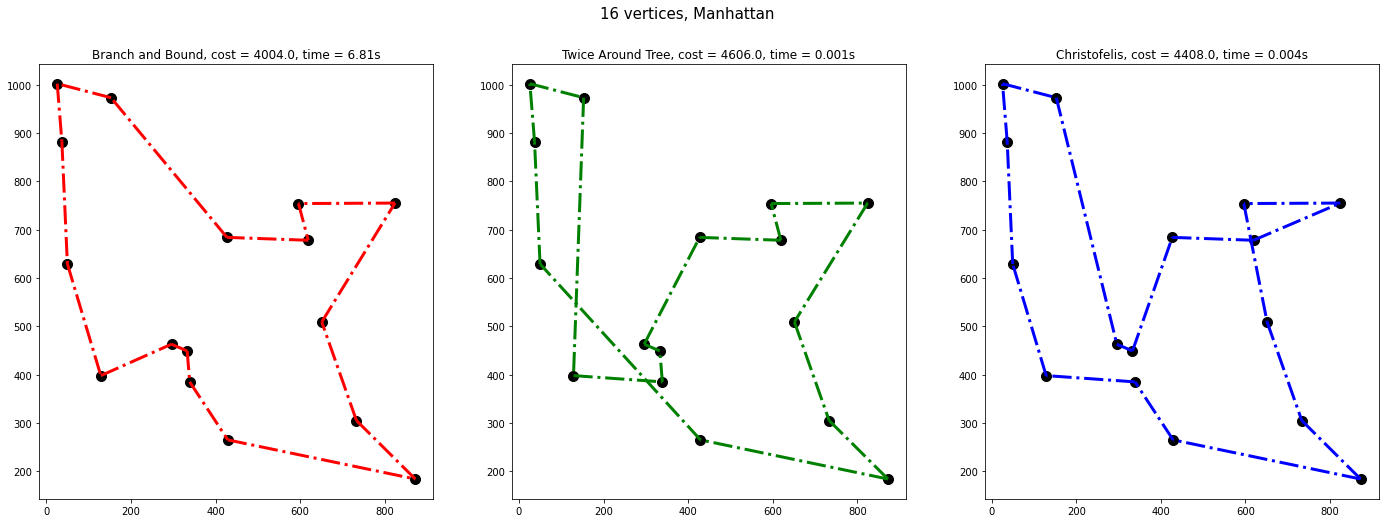

In [ ]:
for i in range(10):
  V = generate_instance(4)
  
  BnB = TSP_BranchAndBound(V, timing=True)
  TAT = TSP_TwiceAroundTree(V, timing=True)
  Chris = TSP_Christofides(V, timing=True)
  compare_3(V, BnB, TAT, Chris)

  BnB = TSP_BranchAndBound(V, timing=True, cost=manhattan)
  TAT = TSP_TwiceAroundTree(V, timing=True, cost=manhattan)
  Chris = TSP_Christofides(V, timing=True, cost=manhattan)
  compare_3(V, BnB, TAT, Chris, 'Manhattan')

So far we can already see that Branch and Bound has the slowest run, but is the only one that manages to find the optimal answer. And since running it with 32 elements is just bad for my computer, let's test it using smaller instances of 4, 8 and 16 element.

In [ ]:
# Calculate mean and standard deviation
# from list of numbers.

def generate_stats(L):
  return np.mean(L), np.std(L)

def plot_stats(L, name=''):
  fig, axs = plt.subplots(1,2, figsize=(24,8))
  
  axs[0].set_title('Boxplot')
  axs[0].boxplot(L, vert=False)

  axs[1].set_title('Distribution')
  axs[1].hist(L, bins=50)

  if name != '':
    fig.suptitle(name, fontsize=15)
  plt.show()

Stats for 4 elements
Mean time:				 0.0002524566650390625
Standard Deviation:		 4.972352256135834e-05
Boxplot below


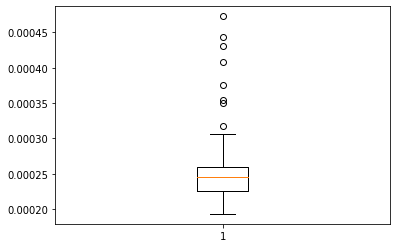


Stats for 8 elements
Mean time:				 0.006020092964172363
Standard Deviation:		 0.00912864583979246
Boxplot below


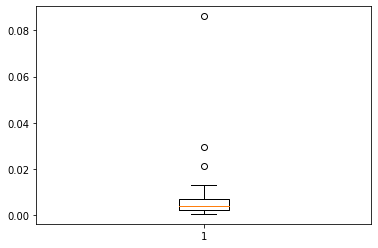

Stats for 16 elements
Mean time:				 23.37354175567627
Standard Deviation:		 66.69489960024974
Boxplot below


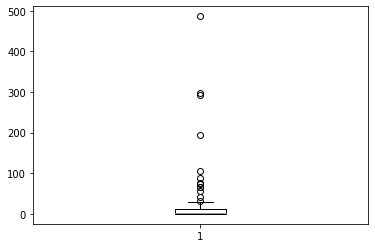

In [ ]:
sample_size = 100
size = [2,3,4]

time4 = []
time8 = []
time16 = []

for _ in range(sample_size):
  V = generate_instance(2)
  sol = TSP_BranchAndBound(V,timing=True)
  time4.append(sol[1])

  V = generate_instance(3)
  sol = TSP_BranchAndBound(V,timing=True)
  time8.append(sol[1])

  V = generate_instance(4)
  sol = TSP_BranchAndBound(V,timing=True)
  time16.append(sol[1])

mean, std = generate_stats(time4)
print('Stats for 4 elements')
print('Mean time:\t\t\t\t', mean)
print('Standard Deviation:\t\t', std)
print('Boxplot below')
plt.boxplot(time4)
plt.show()

mean, std = generate_stats(time8)
print()
print('Stats for 8 elements')
print('Mean time:\t\t\t\t', mean)
print('Standard Deviation:\t\t', std)
print('View below')
plt.boxplot(time8)
plt.show()

mean, std = generate_stats(time16)
print()
print('Stats for 16 elements')
print('Mean time:\t\t\t\t', mean)
print('Standard Deviation:\t\t', std)
print('View below')
plt.boxplot(time16)
plt.show()

The deviation to be many times the mean is not a good sign, let's make a bar graphic to better visualize this result.

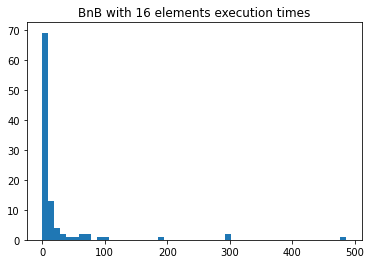

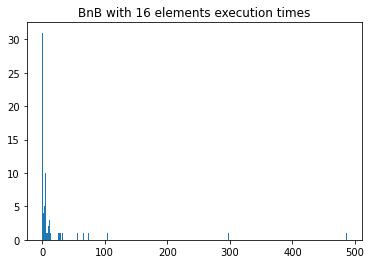

In [ ]:
plt.hist(time16, bins=50)
plt.title('BnB with 16 elements execution times')
plt.show()
plt.hist(time16, bins=500)
plt.title('BnB with 16 elements execution times')
plt.show()

We can see that, while the majority of the execution are within 10s (with times within a single second being the most common), the instances when the algorithm struggles to make good guesses that cut many branches result in execution times as high as 8min

As we can see, while the average case for the Branch and Bound, while still better than the exhaustive search, may result in inacceptably high run times comparable to a exhaustive search used on backtracking algorithms. And even its "good" runs seem to show a exponential growth in time among the tested sizes.

And as we saw before when comparing it to the aproximative algorithms, even its "good" runs are usually many times slower than all the implemented aproximated algorithms.

And as the algorithm requires us to store partial solutions, we will not run larger

Now for the algorithms that have some efficiency, let's start by comparing different sizes of Twice Around Tree and Christofides.

In [ ]:
for i in range(4,11):
  V = generate_instance(i)
  
  TAT = TSP_TwiceAroundTree(V, timing=True)
  Chris = TSP_Christofides(V, timing=True)
  compare_2(V, TAT, Chris)

  TAT = TSP_TwiceAroundTree(V, timing=True, cost=manhattan)
  Chris = TSP_Christofides(V, timing=True, cost=manhattan)
  compare_2(V, TAT, Chris, 'Manhattan')

Output hidden; open in https://colab.research.google.com to view.

Now let's do some meaningfull testing. Using multiple instances of a defined size, let's compare their average cost and execution time. Since both share the steps to calculate adjacency matrix and minimum spanning tree, we also will calculate outside of the algorithms and pass them as arguments to speedup the testing, then adding the time to both.

For the sake of consistancy, we only use the euclidian distance for this test.

In [ ]:
sample_size = 100
size = 10

cost_TAT = []
cost_Chris = []

time_TAT = []
time_Chris = []

time_A = []
time_T = []

for _ in range(sample_size):
  V = generate_instance(size)
  A, timeA = adj(V, timing=True)
  T, timeT = Prims_MST(V,A,timing=True)

  TAT = TSP_TwiceAroundTree(V,A,T,timing=True)
  cost_TAT.append(TAT[0])
  time_TAT.append(TAT[1] + timeA + timeT)

  Chris = TSP_Christofides(V,A,T,timing=True)
  cost_Chris.append(Chris[0])
  time_Chris.append(Chris[1] + timeA + timeT)

  time_A.append(timeA)
  time_T.append(timeT)

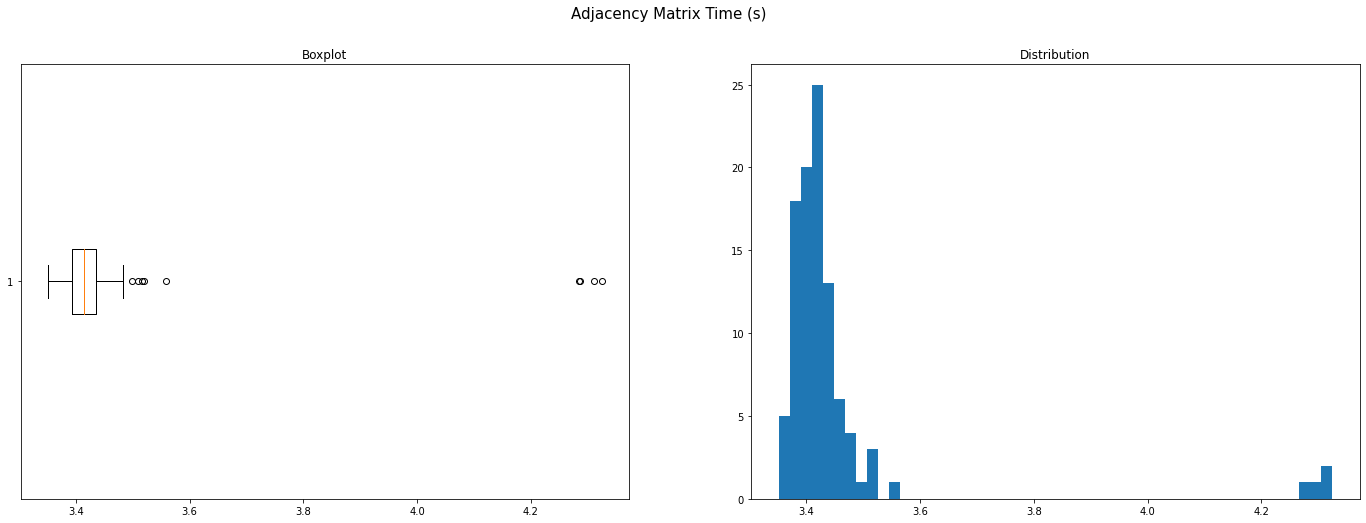

Adjacency Matrix
Mean time:					 3.4526749062538147
Standard Deviation			 0.17698237070581996



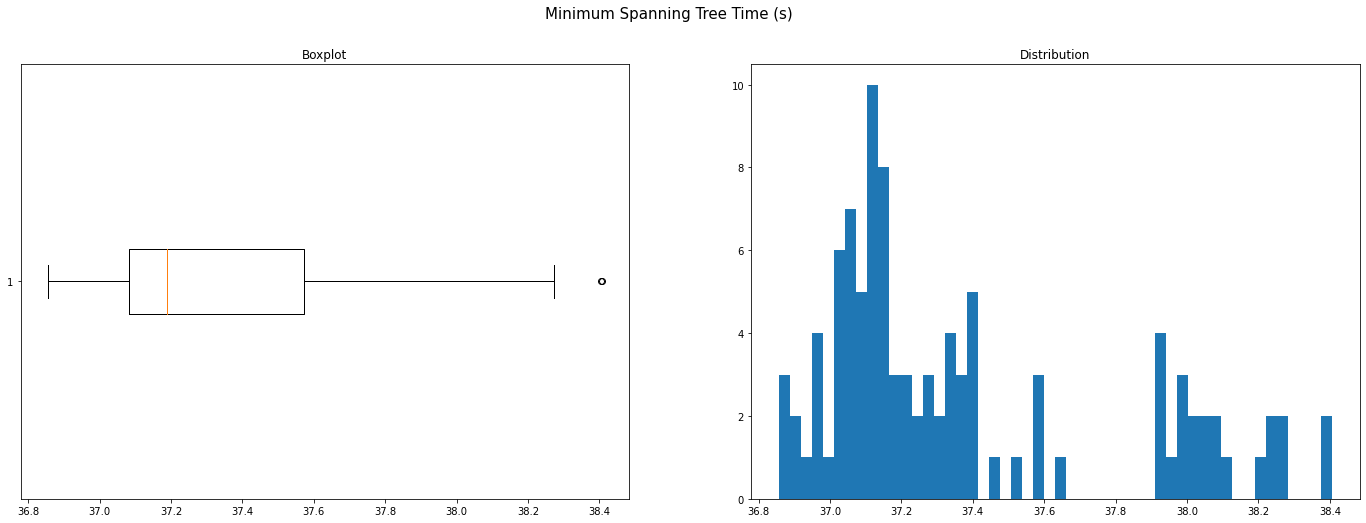

Minimum Spanning Tree
Mean time:					 37.375230054855344
Standard Deviation			 0.4184076710998953



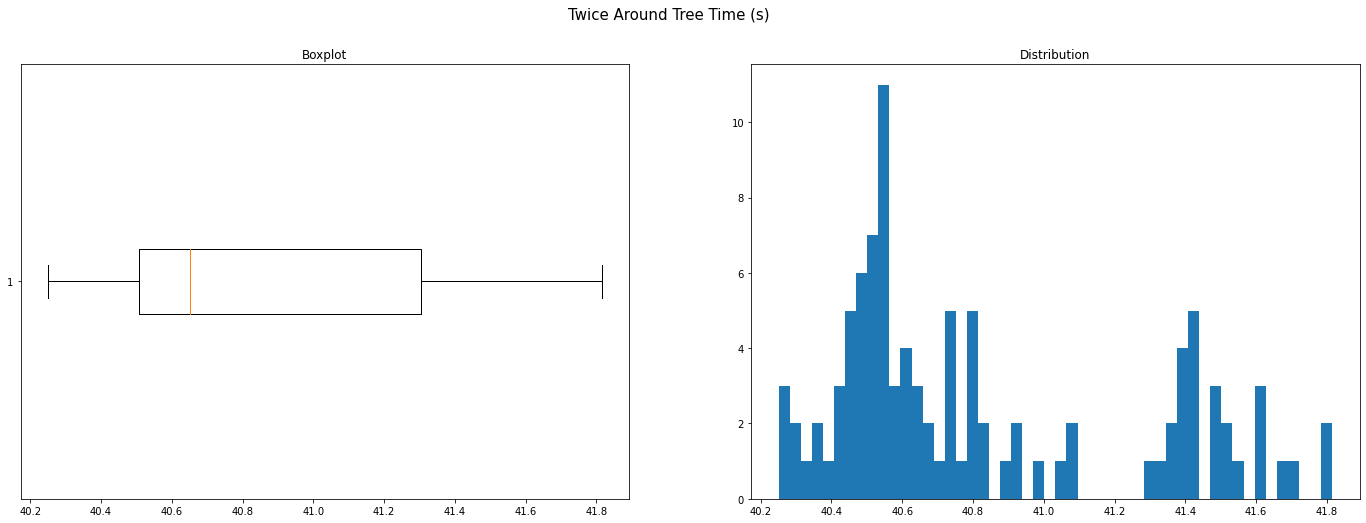

Twice Around Tree
Mean time:							 40.82905326128006
Standard Deviation					 0.43342770508721823
Time Breakdown
Generating adjacency matrix			 0.0845641676812559
Generating minumum spanning tree	 0.9154077077339404



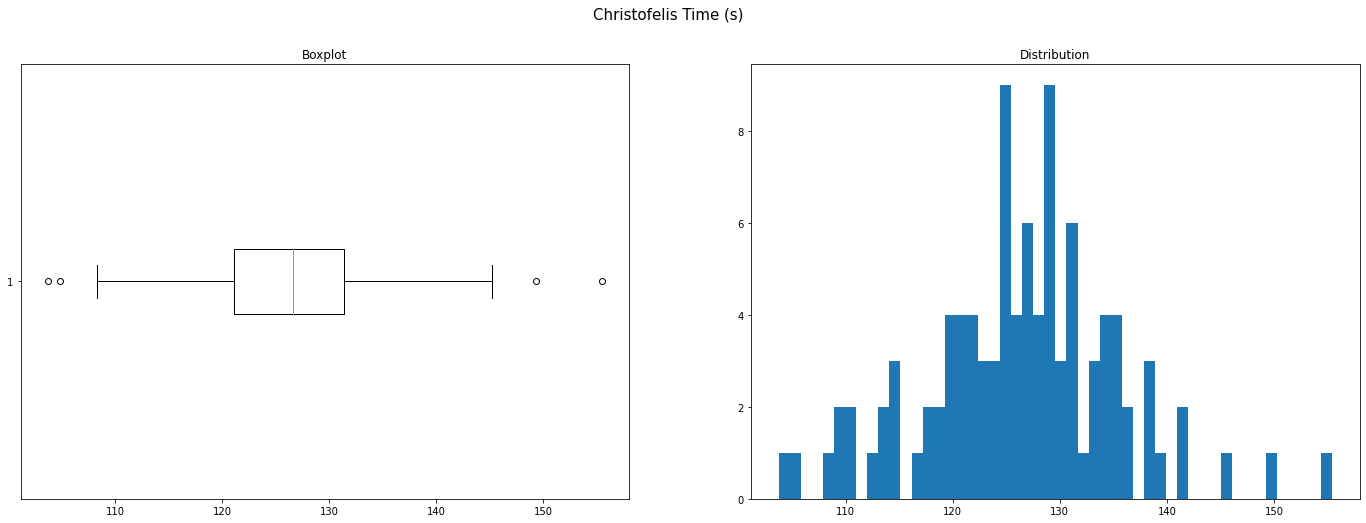

Christofelis
Mean time:							 126.28771390914918
Standard Deviation					 9.000289139530205
Time Breakdown
Generating adjacency matrix			 0.027339753008259013
Generating minumum spanning tree	 0.295953017898027
Minimum Matching + Eulerian			 0.676707229093714


In [ ]:
meanA, stdA = generate_stats(time_A)
meanT, stdT = generate_stats(time_T)

plot_stats(time_A, 'Adjacency Matrix Time (s)')
print('Adjacency Matrix')
print('Mean time:\t\t\t\t\t', meanA)
print('Standard Deviation\t\t\t', stdA)
print()

plot_stats(time_T, 'Minimum Spanning Tree Time (s)')
print('Minimum Spanning Tree')
print('Mean time:\t\t\t\t\t', meanT)
print('Standard Deviation\t\t\t', stdT)
print()

plot_stats(time_TAT, 'Twice Around Tree Time (s)')
mean, std = generate_stats(time_TAT)
print('Twice Around Tree')
print('Mean time:\t\t\t\t\t\t\t', mean)
print('Standard Deviation\t\t\t\t\t', std)
print('Time Breakdown')
print('Generating adjacency matrix\t\t\t', meanA/mean)
print('Generating minumum spanning tree\t', meanT/mean)
print()

plot_stats(time_Chris, 'Christofides Time (s)')
mean, std = generate_stats(time_Chris)
print('Christofelis')
print('Mean time:\t\t\t\t\t\t\t', mean)
print('Standard Deviation\t\t\t\t\t', std)
print('Time Breakdown')
print('Generating adjacency matrix\t\t\t', meanA/mean)
print('Generating minumum spanning tree\t', meanT/mean)
print('Minimum Matching + Eulerian\t\t\t', 1 - (meanA + meanT)/mean)

Now, since be know the Christofides has consistently a better result, but a slower run, lasts compare directly the time and cost of each

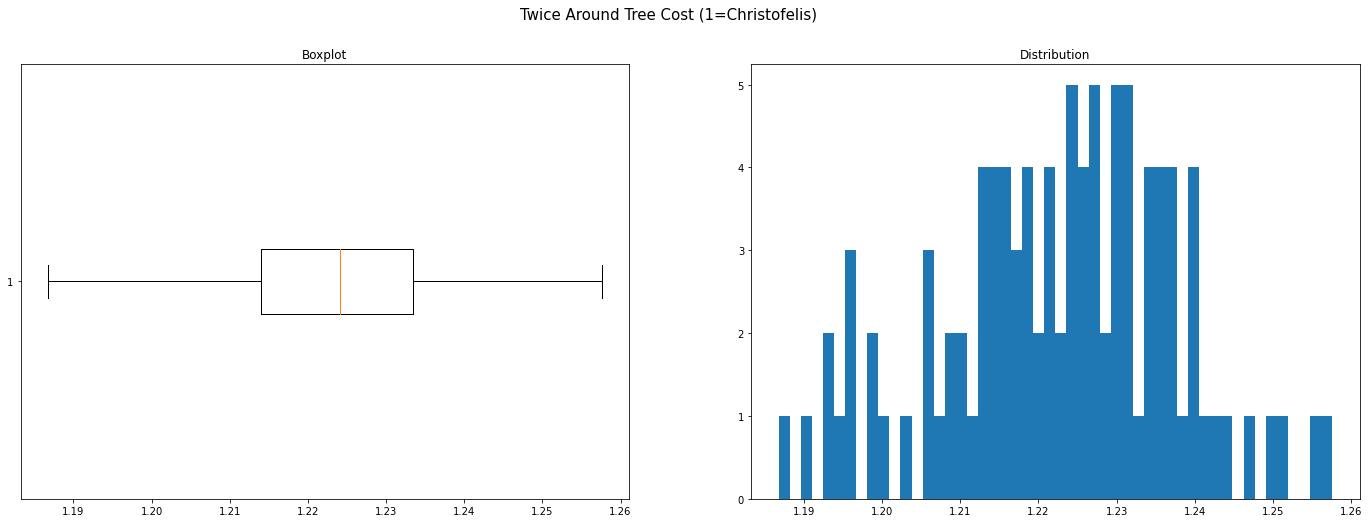

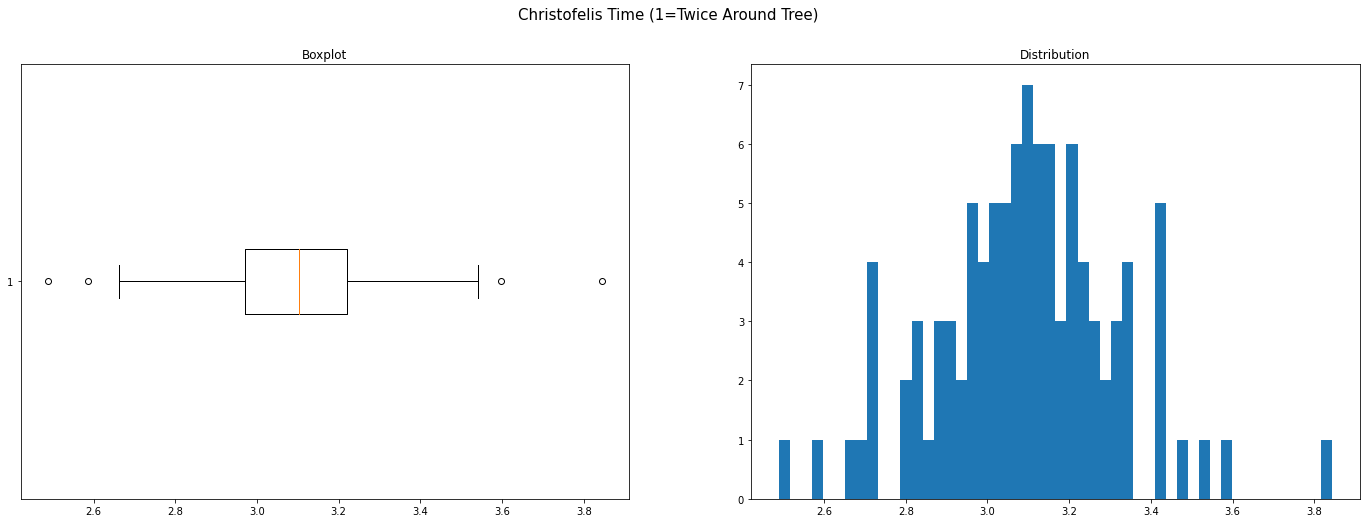

In [ ]:
cost = [i/j for i, j in zip(map(float,cost_TAT), map(float,cost_Chris))]
plot_stats(cost,'Twice Around Tree Cost (1=Christofides)')

time = [i/j for i, j in zip(map(float,time_Chris), map(float,time_TAT))]
plot_stats(time,'Christofides Time (1=Twice Around Tree)')